In [1]:
from sklearn import datasets

iris = datasets.load_iris()

In [2]:
import numpy as np

labels = np.array([[iris['target_names'][iris['target'][i]]] for i in range(len(iris['target']))],dtype=object)

# строчки будут вида [4.9 3.1 1.5 0.2 'setosa'], [5.5 2.4 3.8 1.1 'versicolor'] и т.д.
data = np.append(np.array(iris['data'],dtype=object), labels, axis=1)

# print(data)

In [3]:
def class_counts(arr):
    """считает количество цветков каждого типа"""
    counts = {} 
    unique, count = np.unique(arr[:,-1], return_counts=True)
    for i in range(len(unique)):
        counts[unique[i]] = count[i]
    return counts, count

In [4]:
header = ["sepal length", "sepal width", "petal length", "petal width"]

class Question:
    """Вопросы, которые используются чтобы разделить датасет на два подмножества."""

    def __init__(self, column, value):
        self.column = column
        self.value = value

    def match(self, example):
        """ Удовлетворяет ли элемент условию вопроса"""
        return example[self.column] >= self.value
        

    def __repr__(self):
        return f"Is {header[self.column]} >= {str(self.value)}"

In [5]:
def gini(arr):
    """Считает загрязнённость датасета. Для каждой метки находится
    вероятность того, что случайно выбранный элемент датасета имеет эту метку. """
    _, count = class_counts(arr)
    return 1 - np.sum((count/np.sum(count))**2)

In [6]:
def info_gain(left, right, current_uncertainty):
    """считает насколько хорошо данный вопрос делит датасет.
    от изначальной загрязненности отнимается взвешенная загрязненность подмножеств"""
    p = float(len(left)) / (len(left) + len(right))
    return current_uncertainty - p * gini(left) - (1 - p) * gini(right)

In [7]:
def find_best_split(arr):
    """Находится лучший вопрос (на котором функция info_gain принимает наибольшее значение)
    Возвращается лучший вопрос и значение info_gain на нём"""
    best_gain = 0  
    best_question = None 
    current_uncertainty = gini(arr)
    n_features = len(arr[0]) - 1 

    for col in range(n_features):

        values = set([row[col] for row in arr])

        for val in values: 

            question = Question(col, val)

            # пытаемся разделить
            true_arr = arr[arr[:,col]>=val,:]
            false_arr = arr[arr[:,col]<val,:]

            # Если хоть одно подмножество длины ноль, ищем другой вопрос
            if not len(true_arr)*len(false_arr):
                continue

            # Иначе считаем, насколько изменилась загрязнённость
            gain = info_gain(true_arr, false_arr, current_uncertainty)

            if gain >= best_gain:
                best_gain, best_question = gain, question

    return best_gain, best_question

In [8]:
class Leaf:
    """Лист дерева. Хранит словарь {label: count_of_label}"""

    def __init__(self, arr):
        self.predictions, _ = class_counts(arr)
        
        
class Decision_Node:
    """Внутренний узел дерева. 
    Хранит вопрос, который делит этот узел и ветки, на которые поделится датасет"""

    def __init__(self, question, true_branch, false_branch, arr):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch
        self.arr = arr
        

In [9]:
def build_tree(arr):
    """Решающее дерево"""

    gain, question = find_best_split(arr)

    if gain == 0:
        return Leaf(arr)

    true_arr = arr[arr[:,question.column]>=question.value,:]
    false_arr = arr[arr[:,question.column]<question.value,:]

    true_branch = build_tree(true_arr)
    false_branch = build_tree(false_arr)

    return Decision_Node(question, true_branch, false_branch, arr)

In [10]:
def print_tree(node, spacing=""):
    """Нарисовать схему вопросов, характеризующую это дерево"""

    if isinstance(node, Leaf):
        print (spacing + "Predict", node.predictions)
        return

    print (spacing + str(node.question))

    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [11]:
# функции для отображения каждого листа

def classify(row, node):
    if isinstance(node, Leaf):
        return node.predictions

    if node.question.match(row):
        return classify(row, node.true_branch)
    else:
        return classify(row, node.false_branch)
    
def print_leaf(counts):
    total = float(sum(counts.values()))
    probs = {}
    for label in counts.keys():
        probs[label] = str(int(counts[label] / total * 100)) + "%"
    return probs

def test_data(data, tree):
    summa = 0
    for row in data:
        predictions = classify(row, tree)
        print(f"Метка: {row[-1]}. Предполагаемая метка: {print_leaf(predictions)}")
        cur_sum = predictions[row[-1]] if row[-1] in predictions else 0
        summa += cur_sum/float(sum(predictions.values()))
    print('Точность этого дерева:', summa/len(data))

In [12]:
# Рисуем как каждый вопрос разделяет данные
# Вертикальная линия символизирует разделение на два подмножества
# Точки - элементы множества со значением параметра, откладываемым по оси абсцисс
# значение по ординате символизирует вид цветка. 1 - setosa, 3 - virginica, 5 - versicolor

import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button

def plot_tree(tree, q:int, cur_q, to_show=True):
    if isinstance(tree, Leaf):
        return cur_q - 1
    if cur_q == q and to_show:
        X = tree.arr[:,tree.question.column]
        Y = np.array([1 if tree.arr[i][-1]=='setosa' else 3 if tree.arr[i][-1]=='virginica' else 5 for i in range(len(tree.arr))])

        q_title = repr(tree.question)
        q_column = header[tree.question.column]
        q_value = tree.question.value
        
        return [cur_q+1, X, Y, q_title, q_column, q_value]
    else:
        q1 = plot_tree(tree.false_branch,q, cur_q+1)
        if type(q1) == list:
            return q1
        q2 = plot_tree(tree.true_branch,q, q1+1)
        if type(q2) == list:
            return q2
    return q2

In [13]:
np.random.shuffle(data)

training_data, testing_data = np.split(data, [int(0.9*len(data))])

def decision_tree(q, is_text, to_show):
    my_tree = build_tree(training_data)
    if is_text:
        print_tree(my_tree)
        test_data(testing_data, my_tree)
    return plot_tree(my_tree, q, 0, to_show)
    
q_max = decision_tree(1000, True, False)


Is petal width >= 1.0
--> True:
  Is petal width >= 1.8
  --> True:
    Is petal length >= 4.9
    --> True:
      Predict {'virginica': 41}
    --> False:
      Is sepal width >= 3.2
      --> True:
        Predict {'versicolor': 1}
      --> False:
        Predict {'virginica': 1}
  --> False:
    Is petal length >= 5.0
    --> True:
      Is petal width >= 1.6
      --> True:
        Is petal length >= 5.8
        --> True:
          Predict {'virginica': 1}
        --> False:
          Predict {'versicolor': 2}
      --> False:
        Predict {'virginica': 2}
    --> False:
      Is petal width >= 1.7
      --> True:
        Predict {'virginica': 1}
      --> False:
        Predict {'versicolor': 38}
--> False:
  Predict {'setosa': 48}
Метка: virginica. Предполагаемая метка: {'virginica': '100%'}
Метка: setosa. Предполагаемая метка: {'setosa': '100%'}
Метка: setosa. Предполагаемая метка: {'setosa': '100%'}
Метка: virginica. Предполагаемая метка: {'virginica': '100%'}
Метка: versic

<IPython.core.display.Javascript object>


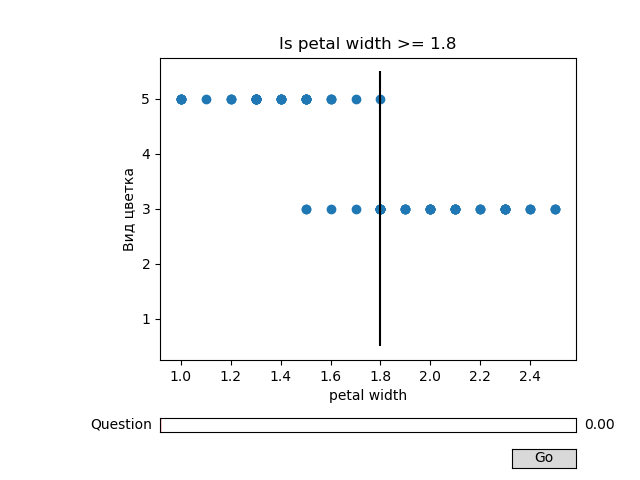

0

In [14]:
%matplotlib notebook
from matplotlib.widgets import Slider, Button

fig, ax = plt.subplots()
plt.subplots_adjust(left=0.25, bottom=0.25)

plt.axis([0, 9, 0, 6])

sfreq = Slider(plt.axes([0.25, 0.1, 0.65, 0.03]), 'Question', 0, q_max, valinit=0)

def go(event):
    q = int(sfreq.val)
    _, X, Y, q_title, q_column, q_value = decision_tree(q, False, True)  
    ax.cla()
    ax.set_title(q_title)
    ax.scatter(X,Y)    
    ax.set_xlabel(q_column)
    ax.set_ylabel('Вид цветка')
    ax.vlines(q_value, 0.5, 5.5)
    plt.draw()
    sfreq.reset()
    
button = Button(plt.axes([0.8, 0.025, 0.1, 0.04]), 'Go')
button.on_clicked(go)

